In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
from scipy import ndimage
import h5py
import math

In [2]:
def load_dataset():
    train_data = h5py.File('C:/Users/a.ezhilarasan/Documents/AI/DeepLearning/CNN/hand_signs/train_signs.h5','r')
    test_data = h5py.File('C:/Users/a.ezhilarasan/Documents/AI/DeepLearning/CNN/hand_signs/test_signs.h5','r')
    train_x = np.array(train_data['train_set_x'][:])
    train_y = np.array(train_data['train_set_y'][:])
    test_x = np.array(test_data['test_set_x'][:])
    test_y = np.array(test_data['test_set_y'][:])
    classes = np.array(test_data['list_classes'][:])
    return train_x, train_y, test_x, test_y, classes

In [3]:
def convert_to_one_hot(a, classes):
    return(np.eye(classes)[a.reshape(-1)])

In [33]:
def random_mini_batches(train_x, train_y, batch_size=64):
    m = train_x.shape[0]
    permutations = list(np.random.permutation(m))
    shuffled_x = train_x[permutations,:,:,:]
    shuffled_y = train_y[permutations,:]
    mini_batches = []
    total_batches = math.floor(m/batch_size)
    
    for k in range(total_batches):
        mini_batch_x = shuffled_x[k*batch_size:k*batch_size+batch_size,:,:,:]
        mini_batch_y = shuffled_y[k*batch_size:k*batch_size+batch_size,:]
        mini_batch = (mini_batch_x,mini_batch_y)
        mini_batches.append(mini_batch)
    
    if(m%batch_size!=0):
        mini_batch_x = shuffled_x[batch_size*total_batches:m,:,:,:]
        mini_batch_y = shuffled_y[batch_size*total_batches:m,:]
        mini_batch = (mini_batch_x,mini_batch_y)
        mini_batches.append(mini_batch)
    
    return mini_batches
    

In [34]:
train_x, train_y, test_x, test_y, classes = load_dataset()

In [92]:
train_x = train_x/255
test_x = test_x/255

In [35]:
train_y = convert_to_one_hot(train_y, 6)
test_y = convert_to_one_hot(test_y, 6)

In [36]:
print("no. of training examples: {}".format(train_x.shape[0]))
print("no. of test examples: {}".format(test_x.shape[0]))
print("shape of train_x: {}".format(train_x.shape))
print("shape of train_y: {}".format(train_y.shape))
print("shape of test_x: {}".format(test_x.shape))
print("shape of test_y: {}".format(test_y.shape))

no. of training examples: 1080
no. of test examples: 120
shape of train_x: (1080, 64, 64, 3)
shape of train_y: (1080, 6)
shape of test_x: (120, 64, 64, 3)
shape of test_y: (120, 6)


In [37]:
len(train_x)

1080

y = [0. 0. 0. 0. 1. 0.]


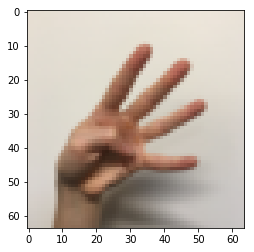

In [93]:
#visualizing few examples
index = 17
img = plt.imshow(train_x[index])
print("y = {}".format(train_y[index]))

In [94]:
def create_placeholders(H, W, ch, classes):
    X = tf.placeholder(tf.float32, shape=[None, H, W, ch])
    Y = tf.placeholder(tf.float32, shape=[None, classes])
    return X, Y


In [95]:
X, Y = create_placeholders(train_x.shape[1],train_x.shape[2],train_x.shape[3],train_y.shape[1])
print("X: ",X)
print("Y: ",Y)

X:  Tensor("Placeholder_4:0", shape=(?, 64, 64, 3), dtype=float32)
Y:  Tensor("Placeholder_5:0", shape=(?, 6), dtype=float32)


In [111]:
#initialize weights and biases for the first convolution layer
w_c1 = tf.Variable(tf.random_normal([5,5,3,64]))
#b_c1 = tf.Variable(tf.random_normal([32])) --not used

In [112]:
def conv2d(x, w):
    return(tf.nn.conv2d(x,w,strides=[1,1,1,1],padding='SAME'))

In [113]:
def maxpool2d(x):
    return(tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME'))

In [99]:
#First convolution layer
conv1 = tf.nn.relu(conv2d(X,w_c1))
#after convolution the output dimension will  be 64 x 64 x 64 as we used 'SAME' padding
conv1 = maxpool2d(conv1)
#after pooling the output dimension will be 32 x 32 x 64 as we set the pooling window as 2.

In [100]:
#initialize weights and biases for the 2nd conv layer
w_c2 = tf.Variable(tf.random_normal([7,7,64,64]))

In [101]:
conv2 = tf.nn.relu(conv2d(conv1, w_c2))
#output dim - 32 x 32 x 64
conv2 = maxpool2d(conv2)
#output dimension will now be 16 x 16 x 64

In [102]:
x_flattened = tf.reshape(conv2, [-1, 16*16*64])
#weights and bias for FC layer
w_fc = tf.Variable(tf.random_normal([16*16*64,1024]))
b_fc = tf.Variable(tf.random_normal([1024]))

In [103]:
#FC layer
fc_layer = tf.nn.relu(tf.matmul(x_flattened, w_fc) + b_fc)

In [104]:
#weights and bias of output layer
w_out = tf.Variable(tf.random_normal([1024,6]))
b_out = tf.Variable(tf.random_normal([6]))


In [105]:
#output layer
yhat = tf.nn.softmax(tf.matmul(fc_layer, w_out) + b_out)

In [106]:
epochs = 100
learning_rate = 0.009
batch_size = 100

In [107]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=yhat, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cross_entropy)

In [108]:
correct_prediction = tf.equal(tf.arg_max(yhat,1),tf.arg_max(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))

In [109]:
minibatches = random_mini_batches(train_x, train_y, batch_size)
(mini_batch_x, mini_batch_y) = minibatches[10]
print(len(minibatches))
print(mini_batch_x)

11
[[[[0.90980392 0.88627451 0.8627451 ]
   [0.90980392 0.89019608 0.8627451 ]
   [0.90980392 0.89019608 0.8627451 ]
   ...
   [0.88235294 0.85882353 0.83137255]
   [0.87843137 0.85490196 0.83137255]
   [0.8745098  0.85098039 0.81960784]]

  [[0.90980392 0.89019608 0.85882353]
   [0.90980392 0.89019608 0.8627451 ]
   [0.90980392 0.89019608 0.86666667]
   ...
   [0.87843137 0.85882353 0.83137255]
   [0.87843137 0.85490196 0.82745098]
   [0.8745098  0.85098039 0.82352941]]

  [[0.90980392 0.89019608 0.85882353]
   [0.90980392 0.89019608 0.8627451 ]
   [0.90980392 0.89019608 0.86666667]
   ...
   [0.8745098  0.85098039 0.82745098]
   [0.87058824 0.84705882 0.82352941]
   [0.86666667 0.84705882 0.81568627]]

  ...

  [[0.84313725 0.82352941 0.79607843]
   [0.84705882 0.82352941 0.79607843]
   [0.84705882 0.82352941 0.79607843]
   ...
   [0.77647059 0.7372549  0.70980392]
   [0.78039216 0.74117647 0.70980392]
   [0.77647059 0.74117647 0.70588235]]

  [[0.84313725 0.81960784 0.79215686]
   [

In [110]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    costs = []
    m = train_x.shape[0]
    total_batches = int(len(train_x) / batch_size)
    for epoch in range(epochs):
        avg_cost = 0
        minibatches = random_mini_batches(train_x, train_y, batch_size)
        #num_minibatches = int(m/batch_size)
        for mini_batch in minibatches:
            (mini_batch_x, mini_batch_y) = mini_batch
            _,temp_cost = sess.run([optimizer, cross_entropy],feed_dict={X:mini_batch_x,Y:mini_batch_y})
            avg_cost += temp_cost/total_batches
        costs.append(avg_cost)
        if(epoch%5==0):
            print("Epoch: {} avg_cost: {}".format(epoch, avg_cost))
    plt.plot(np.squeeze(costs))
    plt.xlabel('learning_rate')
    plt.ylabel('costs')
    plt.title('Error rate')
    train_acc = sess.run(accuracy, feed_dict={X:train_x, Y:train_y})
    test_acc = sess.run(accuracy, feed_dict={X:test_x, Y:test_y})
    print('Accuracy on train set: ',train_acc)
    print('Accuracy on test set: ',test_acc)

Epoch: 0 avg_cost: 2.0652009487152103
Epoch: 5 avg_cost: 2.0657009363174437


KeyboardInterrupt: 